Everything on CPU

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import BatchNormalization, ELU, LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Bidirectional, Input, Flatten, Activation, Reshape, RepeatVector, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

from utils import *

import warnings
warnings.filterwarnings("ignore")

In [107]:
print(tf.__version__)

2.15.0


In [108]:
tf.random.set_seed(2024)
np.random.seed(2024)

In [109]:
tukey = pd.read_pickle('data/tukey_estimates.pkl')

stocks_returns = pd.read_pickle('data/stocks_returns.pkl')

index = pd.read_pickle('data/SX5E_index.pkl')

In [110]:
LOOK_BACK = 15
n_features = len(tukey.columns)
FORECAST_RANGE = 1

We want to start wit hthe first obsrvation of the actual test set (the whole 2018 year). However our model expect as input the previous 15 observations to perform a prediction. We need to "add" the last 15 observatin of the training set to the testing set.  

In [111]:
starting_date_test = tukey.loc[:'2017-01-02'].index[-(LOOK_BACK+1)]
starting_date_test

Timestamp('2016-12-08 00:00:00')

In [112]:
train_price, test_price = tukey.loc[:'2017-01-02'], tukey.loc[starting_date_test:]

In [113]:
train_price.shape, test_price.shape

((1016, 41), (269, 41))

In [114]:
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_price)
scaled_test = scaler.transform(test_price)

In [115]:
X_train, y_train = split_sequence(scaled_train, look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)
X_test, y_test = split_sequence(scaled_test, look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)
print('(Samples, time steps, features)')
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(Samples, time steps, features)
(1001, 15, 41)
(1001, 1, 41)
(254, 15, 41)
(254, 1, 41)


In [116]:
pd.DataFrame(scaled_train).head(16)

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,0.541517,0.461622,0.034626,0.257120,0.013959,0.100755,0.169548,0.251664,0.429280,0.069447,...,0.016829,0.490880,0.029139,0.324387,0.173636,0.852899,0.899366,0.831756,0.049210,0.067080
1,0.529201,0.461799,0.034262,0.278435,0.003311,0.105064,0.177072,0.242479,0.415421,0.069170,...,0.007411,0.499854,0.019105,0.311892,0.180203,0.844386,0.895234,0.851984,0.042860,0.071488
2,0.516797,0.457860,0.036727,0.296042,0.000000,0.111241,0.184239,0.232479,0.412488,0.061482,...,0.006851,0.517925,0.012021,0.303981,0.189000,0.850401,0.895617,0.872443,0.035237,0.076776
3,0.507911,0.447295,0.034189,0.308523,0.004506,0.120639,0.181054,0.216559,0.409791,0.051458,...,0.000000,0.539547,0.008036,0.297443,0.197833,0.857331,0.891148,0.892111,0.023188,0.088735
4,0.508034,0.438925,0.037815,0.311910,0.032780,0.131367,0.187847,0.208864,0.419323,0.052887,...,0.000213,0.566854,0.008782,0.300046,0.204064,0.877588,0.891316,0.905895,0.018373,0.097186
5,0.511512,0.422013,0.041265,0.309480,0.062710,0.139578,0.178564,0.201452,0.420097,0.056054,...,0.002047,0.569700,0.009469,0.304128,0.211047,0.882571,0.890789,0.912355,0.015429,0.100457
6,0.521391,0.414747,0.040609,0.312093,0.061864,0.144239,0.165171,0.203834,0.430032,0.054294,...,0.004082,0.569046,0.004827,0.296455,0.212109,0.888026,0.879558,0.912538,0.022499,0.095597
7,0.522908,0.406736,0.044093,0.281079,0.061828,0.142693,0.157912,0.216265,0.429174,0.051623,...,0.013135,0.573871,0.000000,0.272436,0.210314,0.894143,0.863180,0.907484,0.033346,0.091237
8,0.526643,0.404740,0.043780,0.278568,0.063943,0.142578,0.153651,0.230493,0.420234,0.050776,...,0.027586,0.576559,0.002892,0.238750,0.206102,0.893838,0.852046,0.902328,0.037035,0.091054
9,0.530767,0.401711,0.042236,0.284384,0.087248,0.146637,0.145950,0.244864,0.413457,0.048868,...,0.039572,0.581729,0.024220,0.222509,0.197721,0.892704,0.842585,0.900060,0.044900,0.087584


In [117]:
y_train[0]

array([[0.57375545, 0.39893146, 0.06437328, 0.34211954, 0.18468364,
        0.14757604, 0.15820193, 0.23146491, 0.39263385, 0.04239953,
        0.14298896, 0.35850345, 0.01814811, 0.11799181, 0.4457627 ,
        0.13601568, 0.4683892 , 0.22343829, 0.11143575, 0.07930505,
        0.08803631, 0.12720957, 0.69378078, 0.10246328, 0.18349875,
        0.16302742, 0.0300701 , 0.14386724, 0.36465103, 0.18063451,
        0.21958413, 0.08440268, 0.57910612, 0.09897563, 0.25675073,
        0.17241916, 0.89049421, 0.77154303, 0.88986581, 0.06280436,
        0.07818394]])

In [118]:
X_train[0]

array([[5.41517497e-01, 4.61622419e-01, 3.46256104e-02, 2.57119733e-01,
        1.39587005e-02, 1.00754654e-01, 1.69547805e-01, 2.51663737e-01,
        4.29279557e-01, 6.94473107e-02, 2.34611053e-01, 3.70297457e-01,
        6.63307122e-02, 1.01872065e-01, 3.91173342e-01, 1.35496571e-01,
        4.08123162e-01, 2.37500855e-01, 1.63170999e-01, 1.17300197e-01,
        7.13347407e-02, 5.41255155e-02, 6.56006825e-01, 6.92384440e-02,
        1.95977993e-01, 1.17170024e-01, 8.86390227e-02, 1.56268167e-01,
        2.09577475e-01, 1.72731754e-01, 3.18454540e-01, 1.68289004e-02,
        4.90879943e-01, 2.91390213e-02, 3.24387023e-01, 1.73635728e-01,
        8.52898807e-01, 8.99365736e-01, 8.31755515e-01, 4.92100648e-02,
        6.70798906e-02],
       [5.29200994e-01, 4.61798844e-01, 3.42617711e-02, 2.78435479e-01,
        3.31113585e-03, 1.05064495e-01, 1.77071786e-01, 2.42479285e-01,
        4.15420725e-01, 6.91696514e-02, 2.15920869e-01, 3.64839847e-01,
        6.54307025e-02, 9.24787579e-02,

In [119]:
X_train.shape

(1001, 15, 41)

Everything matches. Each row of my dataset is an element of the arrays: 1001 samples where each sample has 15 timesteps for each of the 41 stocks. The sequences are ready for training.

### Functions

In [120]:
def inverse_transform(y_test, yhat):
    y_test_reshaped = y_test.reshape(-1, y_test.shape[-1])
    yhat_reshaped = yhat.reshape(-1, yhat.shape[-1])
    yhat_inverse = scaler.inverse_transform(yhat_reshaped)
    y_test_inverse = scaler.inverse_transform(y_test_reshaped)
    return yhat_inverse, y_test_inverse

# aggregated metrics
def evaluate_forecast(y_test_inverse, yhat_inverse):
    mse_ = tf.keras.losses.MeanSquaredError()
    mae_ = tf.keras.losses.MeanAbsoluteError()
    mape_ = tf.keras.losses.MeanAbsolutePercentageError()
    mae = mae_(y_test_inverse,yhat_inverse)
    print('mae:', mae.numpy())
    mse = mse_(y_test_inverse,yhat_inverse)
    print('mse:', mse.numpy())
    mape = mape_(y_test_inverse,yhat_inverse)
    print('mape:', mape.numpy())


# metrics for each stock
def calculate_metrics(y_test_inverse, yhat_inverse, tukey):
    metrics_df = pd.DataFrame(columns=['Stock', 'MAE', 'MSE', 'MAPE'])
    mse_ = tf.keras.losses.MeanSquaredError()
    mae_ = tf.keras.losses.MeanAbsoluteError()
    mape_ = tf.keras.losses.MeanAbsolutePercentageError()

    for stock in range(y_test_inverse.shape[1]):
        stock_name = tukey.iloc[:, stock].name
        mae = mae_(y_test_inverse[:, stock], yhat_inverse[:, stock])
        mse = mse_(y_test_inverse[:, stock], yhat_inverse[:, stock])
        mape = mape_(y_test_inverse[:, stock], yhat_inverse[:, stock])

        metrics_df.loc[len(metrics_df)] = [stock_name, mae.numpy(), mse.numpy(), mape.numpy()]
        # metrics_df = metrics_df.append({'Stock': stock_name, 'MAE': mae.numpy(), 'MSE': mse.numpy(), 'MAPE': mape.numpy()}, ignore_index=True)
    
    return metrics_df


def plot_preds(yhat, ytest, metrics_df, model_name):
    # convert to df for nice plotting
    if isinstance(yhat, np.ndarray):
        predictions = pd.DataFrame(yhat, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)
    if isinstance(ytest, np.ndarray):
        y_test_inverse_df = pd.DataFrame(ytest, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)

    rand = np.random.choice(np.arange(41), size=10, replace=False)      # 10 stock random sample without replacement
    fig, axs = plt.subplots(2, 5, figsize=(20, 8))

    for i, stock in enumerate(rand):
        row = i // 5
        col = i % 5
        axs[row, col].plot(predictions.iloc[:, stock], color='blue',
                           label='Predicted')
        axs[row, col].plot(y_test_inverse_df.iloc[:, stock], color='red', label='Realized')
        axs[row, col].set_title(predictions.iloc[:, stock].name)
        axs[row, col].tick_params(axis='x', rotation=45)
        
        # metrics in top left
        axs[row, col].annotate(f"MAE: {metrics_df.loc[stock, 'MAE']:.2f}\nMSE: {metrics_df.loc[stock, 'MSE']:.2f}\nMAPE: {metrics_df.loc[stock, 'MAPE']:.2f}", 
                               xy=(0.05, 0.95), xycoords='axes fraction', ha='left', va='top', fontsize=10, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.5))

    plt.suptitle(f"{model_name}: predicted vs realized", fontsize=16)
    
    # bottom legend
    handles, labels = axs[0,0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=2)

    plt.tight_layout()
    plt.show()

## Sequence-2-Sequence Modeling (many-to-many) with LSTMs:
Using encoder-decoder architectures to forecast multiple time series with one model. The encoder is basically responsible for reading and interpreting the input. The encoder part compresses the input into a small representation (a fixed-length vector) of the original input, and this "context vector" is given to the decoder part as input to be interpreted and perform forecasting.
- RepeatVector layer is used to repeat N times the context vector we obtain from the encoder part. N is the number of future steps you want to forecast and is fed into the decoder part.
- A fully connected Dense layer is applied to each time step via TimeDistributed wrapper, so separates the output for each time step. The TimeDistributed allows to treat independently each time series.

### LSTM

In [121]:
model_enc_dec = Sequential(name='LSTM')
model_enc_dec.add(LSTM(100, activation='relu', input_shape=(LOOK_BACK, n_features)))
model_enc_dec.add(RepeatVector(FORECAST_RANGE))
model_enc_dec.add(LSTM(100, activation='relu', return_sequences=True))
model_enc_dec.add(TimeDistributed(Dense(n_features)))
model_enc_dec.compile(optimizer='adam', loss='mse')

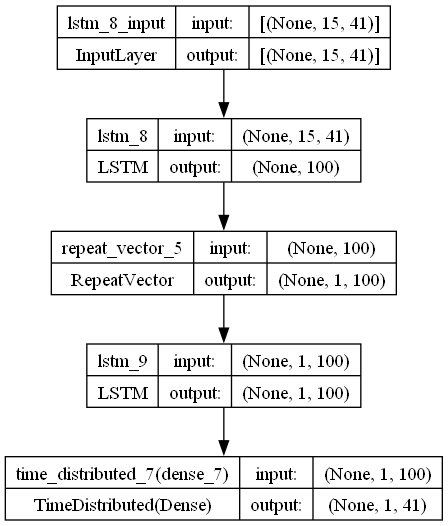

In [122]:
plot_model(model=model_enc_dec, show_shapes=True)

In [123]:
history = model_enc_dec.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50


32/32 [==============================] - 3s 9ms/step - loss: 0.1249
Epoch 2/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0228
Epoch 3/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0112
Epoch 4/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0074
Epoch 5/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0056
Epoch 6/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0046
Epoch 7/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0039
Epoch 8/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0034
Epoch 9/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0030
Epoch 10/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0028
Epoch 11/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0026
Epoch 12/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0025
Epoch 13/50
32/32 [==============================] - 0s 9ms/

In [124]:
yhat = model_enc_dec.predict(X_test, verbose=0)

In [125]:
yhat_inverse, y_test_inverse = inverse_transform(y_test, yhat)

In [126]:
yhat_inverse.shape, y_test_inverse.shape

((254, 41), (254, 41))

In [127]:
evaluate_forecast(y_test_inverse, yhat_inverse)

mae: 3.9148211
mse: 62.439068
mape: 5.8147054


In [128]:
metrics_df = calculate_metrics(y_test_inverse, yhat_inverse, tukey)

In [129]:
metrics_df

,Stock,MAE,MSE,MAPE
0,VOW3 GY Equity,11.426187,240.703064,9.447171
1,ENGI FP Equity,0.403754,0.251956,3.096314
2,BAYN GY Equity,5.520392,50.840672,5.017772
3,BNP FP Equity,1.686985,3.795767,2.704226
4,PHIA NA Equity,1.158622,1.951604,3.868111
5,ISP IM Equity,0.093786,0.013823,3.632079
6,SAN FP Equity,4.427784,25.743128,5.345324
7,MC FP Equity,32.176453,1314.563843,14.034174
8,ENEL IM Equity,0.231675,0.074100,4.740474
9,CS FP Equity,0.970013,1.286154,4.015416


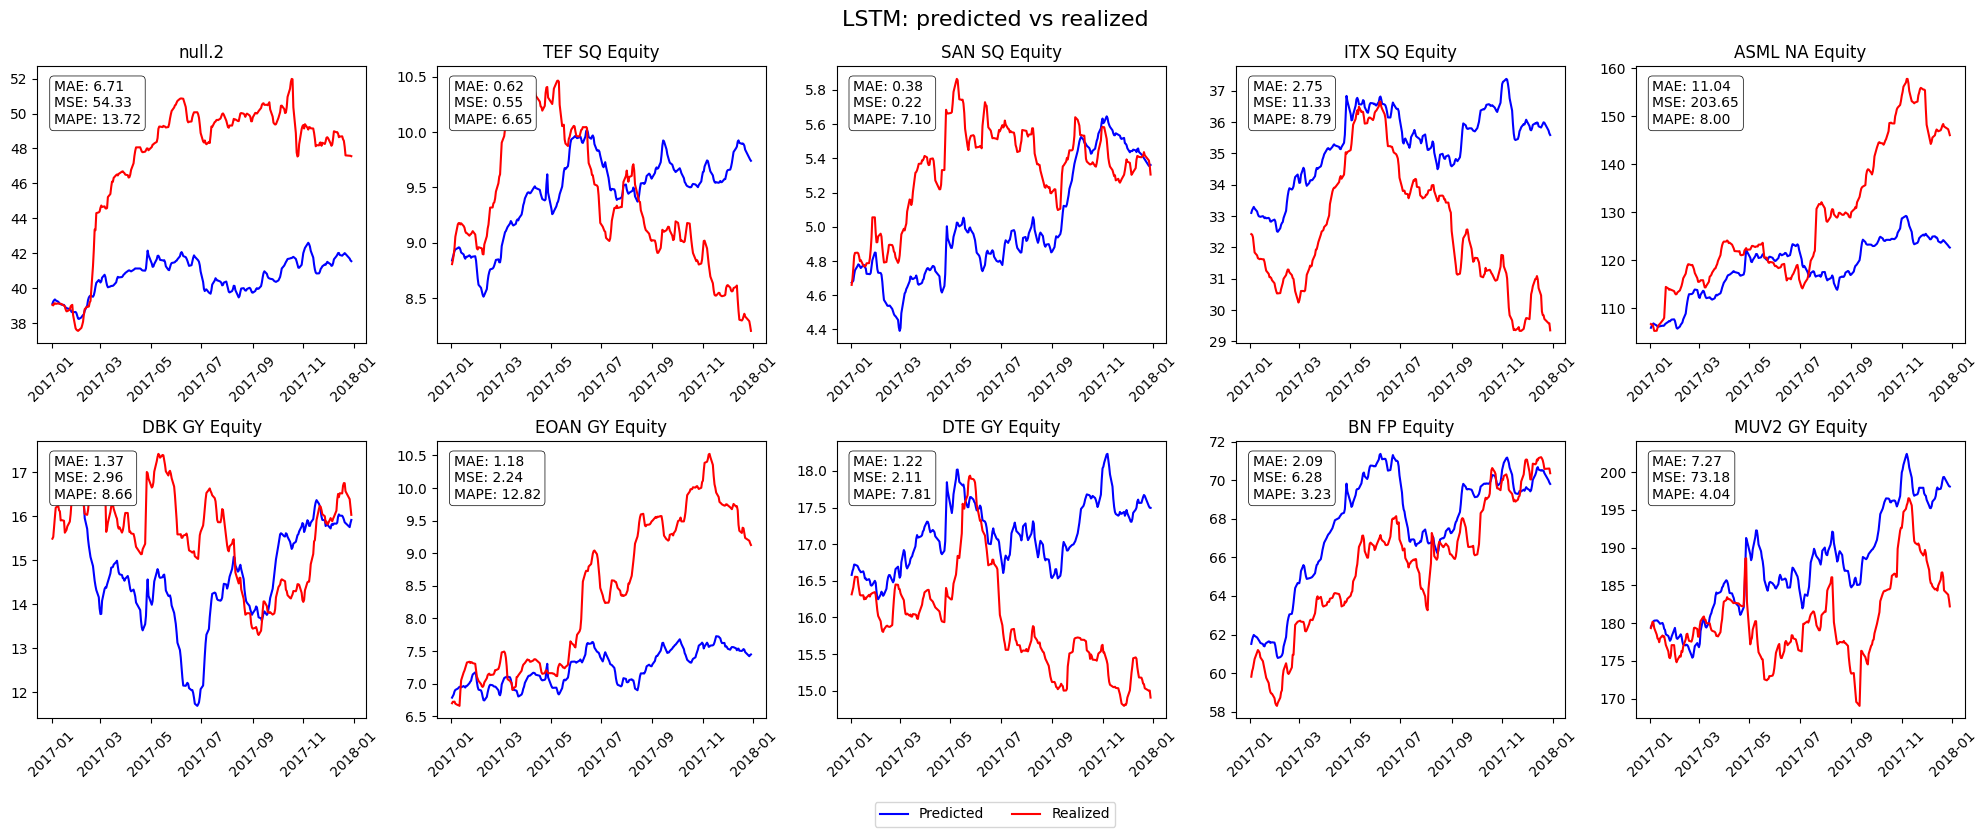

In [130]:
plot_preds(yhat_inverse, y_test_inverse, metrics_df, model_name=model_enc_dec.name)

#### Portfolio creation, optimization and comparison:
- ranking the predictions
- selecting stocks
- calculate performance of portfolios for different N selections
- plot the portfolios
- compare with index

In [131]:
# convert to dataframes
yhat_inverse_df = pd.DataFrame(yhat_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)
y_test_inverse_df = pd.DataFrame(y_test_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)

In [132]:
initial_inv = 1000

test_index_series = index.loc['2017-01-02':]
test_index_series = ((test_index_series / test_index_series.iloc[0]) * initial_inv)
test_index_series = pd.Series(test_index_series['Close'], index = test_index_series.index)

portfolios_LSTM = get_ranking(yhat_inverse_df, N = [5, 7, 10], prices=True)
 
tot_performance_LSTM, portfolio_series_LSTM = calc_portfolios(portfolios_LSTM, tukey.loc[yhat_inverse_df.index[0]:], initial_investment=initial_inv)

tot_performance_LSTM['Index performance'] = ((test_index_series[-1] - test_index_series[0]) / test_index_series[0]) * 100
tot_performance_LSTM

{'Top5 performance': 21.38372258249201,
 'Top7 performance': 19.978505339436083,
 'Top10 performance': 17.02519791537868,
 'Index performance': 7.519056769262942}

In [133]:
plot_portfolios(portfolio_series_LSTM, index_perf = test_index_series)

### CNN encoder - LSTM decoder

In [134]:
cnn_lstm = Sequential(name='CNN-LSTM')
cnn_lstm.add(Conv1D(filters=64, kernel_size=9, activation='relu', input_shape=(LOOK_BACK, n_features)))
cnn_lstm.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
cnn_lstm.add(MaxPooling1D(pool_size=2))
cnn_lstm.add(Flatten())
cnn_lstm.add(RepeatVector(FORECAST_RANGE))
cnn_lstm.add(LSTM(200, activation='relu', return_sequences=True))
cnn_lstm.add(TimeDistributed(Dense(100, activation='relu')))
cnn_lstm.add(TimeDistributed(Dense(n_features)))
cnn_lstm.compile(loss='mse', optimizer='adam')

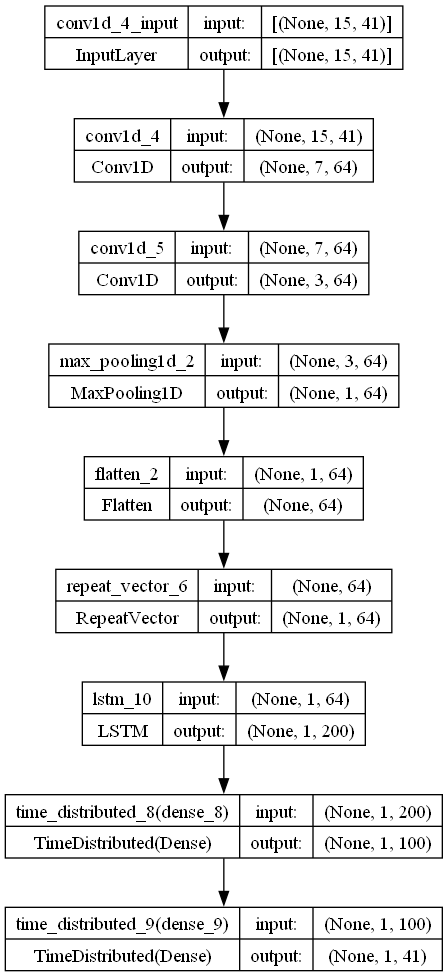

In [135]:
plot_model(model=cnn_lstm, show_shapes=True)

In [136]:
history = cnn_lstm.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
32/32 [==============================] - 2s 6ms/step - loss: 0.1338
Epoch 2/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0324
Epoch 3/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0163
Epoch 4/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0137
Epoch 5/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0115
Epoch 6/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0095
Epoch 7/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0086
Epoch 8/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0077
Epoch 9/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0069
Epoch 10/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0061
Epoch 11/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0056
Epoch 12/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0052
Epoch 13/50
32/32 [==============================

In [137]:
yhat = cnn_lstm.predict(X_test, verbose=0)

In [138]:
yhat_inverse, y_test_inverse = inverse_transform(y_test, yhat)

In [139]:
evaluate_forecast(y_test_inverse, yhat_inverse)

mae: 4.3737493
mse: 59.965107
mape: 7.42496


In [140]:
metrics_df = calculate_metrics(y_test_inverse, yhat_inverse, tukey)

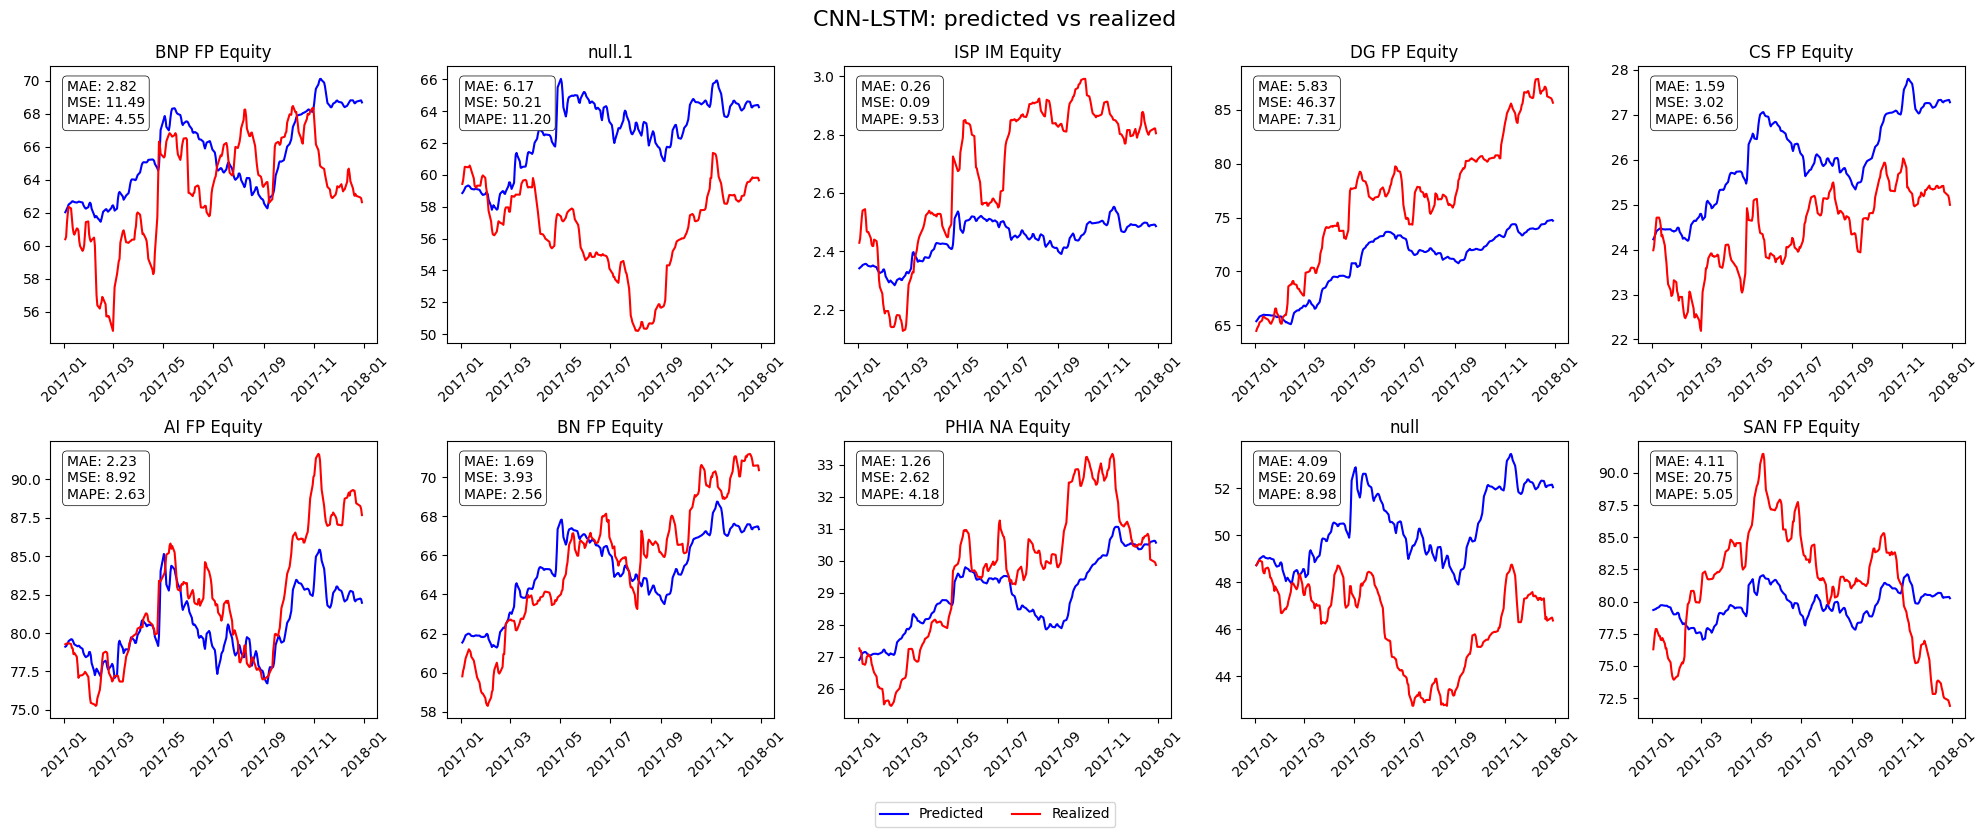

In [141]:
plot_preds(yhat_inverse, y_test_inverse, metrics_df, model_name=cnn_lstm.name)

#### Portfolio creation, optimization and comparison:
- ranking the predictions
- selecting stocks
- calculate performance of portfolios for different N selections
- plot the portfolios
- compare with index

In [142]:
# convert to dataframes
yhat_inverse_df = pd.DataFrame(yhat_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)
y_test_inverse_df = pd.DataFrame(y_test_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)

In [143]:
initial_inv = 1000

test_index_series = index.loc['2017-01-02':]
test_index_series = ((test_index_series / test_index_series.iloc[0]) * initial_inv)
test_index_series = pd.Series(test_index_series['Close'], index = test_index_series.index)

portfolios_CNN_LSTM = get_ranking(yhat_inverse_df, N = [5, 7, 10], prices=True)
 
tot_performance_CNN_LSTM, portfolio_series_CNN_LSTM = calc_portfolios(portfolios_CNN_LSTM, tukey.loc[yhat_inverse_df.index[0]:], initial_investment=initial_inv)

tot_performance_CNN_LSTM['Index performance'] = ((test_index_series[-1] - test_index_series[0]) / test_index_series[0]) * 100
tot_performance_CNN_LSTM

{'Top5 performance': 19.691692003207937,
 'Top7 performance': 20.001396398951645,
 'Top10 performance': 14.178143014563057,
 'Index performance': 7.519056769262942}

In [144]:
plot_portfolios(portfolio_series_CNN_LSTM, test_index_series)

### Multi-Head CNN-LSTM

The multi-head structure uses multiple one-dimensional CNN layers in order to process each time series and extract independent convolved features from each time series. These separate CNNs are called “head” and flattened, concatenated, and reshaped respectively before feeding into the LSTM layer. Therefore, they might be more successful to keep significant features of each time series and make better forecasts in this sense.

In [145]:
input_layer = Input(shape=(LOOK_BACK, n_features)) 
head_list = []
# 41 "heads", each to extract feats from each ts :)
for i in range(0, n_features):
    conv_layer_head = Conv1D(filters=4, kernel_size=7, activation='relu')(input_layer)
    conv_layer_head_2 = Conv1D(filters=6, kernel_size=5, activation='relu')(conv_layer_head)
    conv_layer_flatten = Flatten()(conv_layer_head_2)
    head_list.append(conv_layer_flatten)
 
concat_cnn = Concatenate(axis=1)(head_list)
reshape = Reshape((head_list[0].shape[1], n_features))(concat_cnn)
lstm = LSTM(100, activation='relu')(reshape)
repeat = RepeatVector(FORECAST_RANGE)(lstm)
lstm_2 = LSTM(100, activation='relu', return_sequences=True)(repeat)
dropout = Dropout(0.2)(lstm_2)
dense = Dense(n_features, activation='linear')(dropout)
multi_head_cnn_lstm_model = Model(inputs=input_layer, outputs=dense, name='Multi-Head-CNN-LSTM')

multi_head_cnn_lstm_model.compile(loss='mse', optimizer='adam')

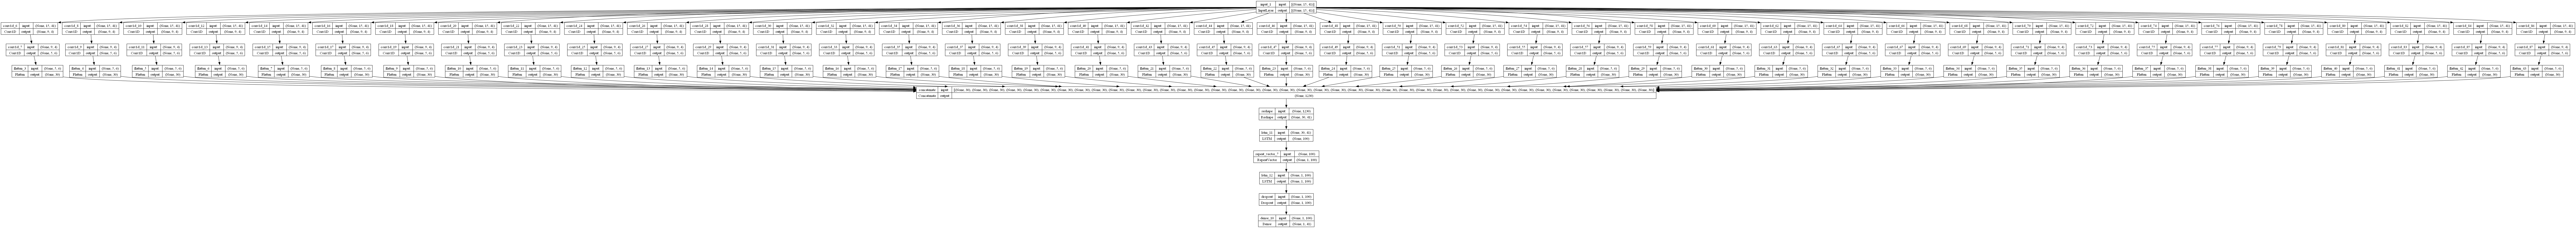

In [146]:
plot_model(model=multi_head_cnn_lstm_model, show_shapes=True)

In [147]:
history = multi_head_cnn_lstm_model.fit(X_train, y_train, epochs=70, batch_size=32)
# 70 epochs to reach global minimum

Epoch 1/70
32/32 [==============================] - 21s 30ms/step - loss: 0.1794
Epoch 2/70
32/32 [==============================] - 1s 27ms/step - loss: 0.0585
Epoch 3/70
32/32 [==============================] - 1s 28ms/step - loss: 0.0487
Epoch 4/70
32/32 [==============================] - 1s 30ms/step - loss: 0.0341
Epoch 5/70
32/32 [==============================] - 1s 26ms/step - loss: 0.0272
Epoch 6/70
32/32 [==============================] - 1s 27ms/step - loss: 0.0242
Epoch 7/70
32/32 [==============================] - 1s 26ms/step - loss: 0.0233
Epoch 8/70
32/32 [==============================] - 1s 31ms/step - loss: 0.0210
Epoch 9/70
32/32 [==============================] - 1s 28ms/step - loss: 0.0196
Epoch 10/70
32/32 [==============================] - 1s 29ms/step - loss: 0.0183
Epoch 11/70
32/32 [==============================] - 1s 32ms/step - loss: 0.0175
Epoch 12/70
32/32 [==============================] - 1s 29ms/step - loss: 0.0165
Epoch 13/70
32/32 [=================

In [148]:
yhat = multi_head_cnn_lstm_model.predict(X_test, verbose=0)

In [149]:
yhat_inverse, y_test_inverse = inverse_transform(y_test, yhat)

In [150]:
evaluate_forecast(y_test_inverse, yhat_inverse)

mae: 4.8254914
mse: 79.79584
mape: 7.4247723


In [151]:
metrics_df = calculate_metrics(y_test_inverse, yhat_inverse, tukey)

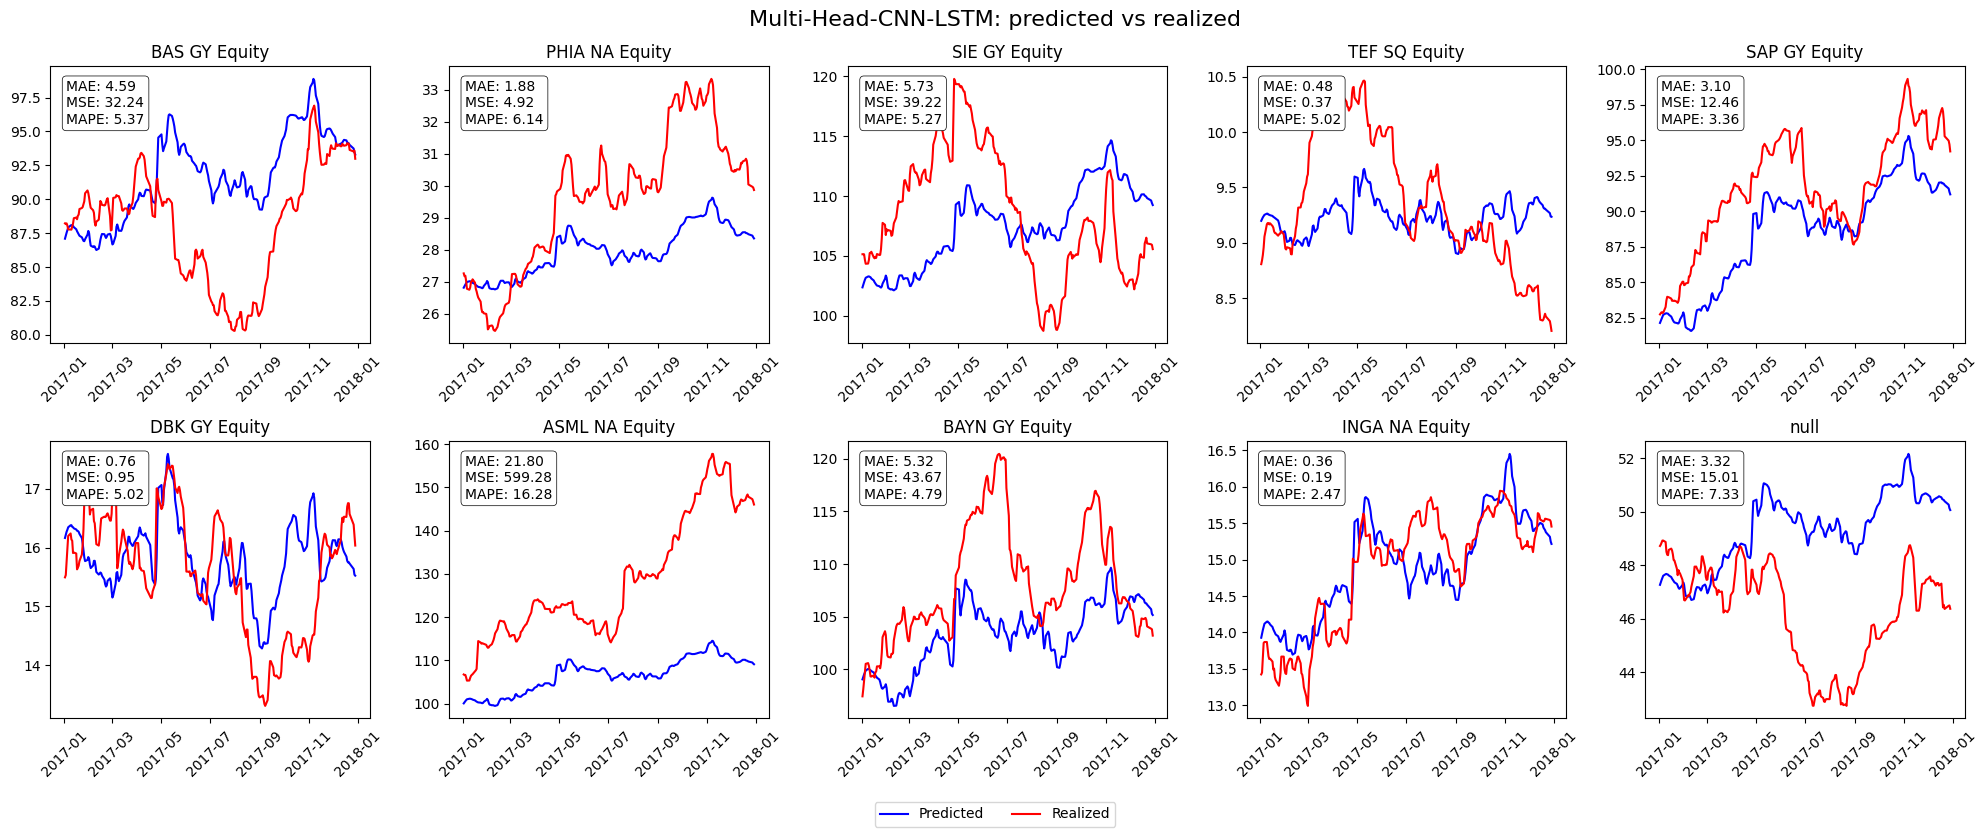

In [152]:
plot_preds(yhat_inverse, y_test_inverse, metrics_df, model_name=multi_head_cnn_lstm_model.name)

#### Portfolio creation, optimization and comparison:
- ranking the predictions
- selecting stocks
- calculate performance of portfolios for different N selections
- plot the portfolios
- compare with index

In [153]:
# convert to dataframes
yhat_inverse_df = pd.DataFrame(yhat_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)
y_test_inverse_df = pd.DataFrame(y_test_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)

In [154]:
initial_inv = 1000

test_index_series = index.loc['2017-01-02':]
test_index_series = ((test_index_series / test_index_series.iloc[0]) * initial_inv)
test_index_series = pd.Series(test_index_series['Close'], index = test_index_series.index)

portfolios_MCNN_LSTM = get_ranking(yhat_inverse_df, N = [5, 7, 10], prices=True)
 
tot_performance_MCNN_LSTM, portfolio_series_MCNN_LSTM = calc_portfolios(portfolios_MCNN_LSTM, tukey.loc[yhat_inverse_df.index[0]:], initial_investment=initial_inv)

tot_performance_MCNN_LSTM['Index performance'] = ((test_index_series[-1] - test_index_series[0]) / test_index_series[0]) * 100
tot_performance_MCNN_LSTM

{'Top5 performance': -2.0083549626667945,
 'Top7 performance': 1.3729433077975046,
 'Top10 performance': 7.213697268585769,
 'Index performance': 7.519056769262942}

In [155]:
plot_portfolios(portfolio_series_MCNN_LSTM, test_index_series)

### CNN-BiLSTM

In [156]:
plot_model(model=cnn_bilstm, show_shapes=True)

NameError: name 'cnn_bilstm' is not defined

In [ ]:
history = cnn_bilstm.fit(X_train, y_train, epochs=50, batch_size=32)

In [ ]:
yhat = cnn_bilstm.predict(X_test, verbose=0)

In [ ]:
yhat_inverse, y_test_inverse = inverse_transform(y_test, yhat)

In [ ]:
evaluate_forecast(y_test_inverse, yhat_inverse)

In [ ]:
metrics_df = calculate_metrics(y_test_inverse, yhat_inverse, tukey)

In [ ]:
plot_preds(yhat_inverse, y_test_inverse, metrics_df, model_name=cnn_bilstm.name)

#### Portfolio creation, optimization and comparison:
- ranking the predictions
- selecting stocks
- calculate performance of portfolios for different N selections
- plot the portfolios
- compare with index

In [ ]:
# convert to dataframes
yhat_inverse_df = pd.DataFrame(yhat_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)
y_test_inverse_df = pd.DataFrame(y_test_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)

In [ ]:
initial_inv = 1000

test_index_series = index.loc['2017-01-02':]
test_index_series = ((test_index_series / test_index_series.iloc[0]) * initial_inv)
test_index_series = pd.Series(test_index_series['Close'], index = test_index_series.index)

portfolios_CNN_biLSTM = get_ranking(yhat_inverse_df, N = [5, 7, 10], prices=True)
 
tot_performance_CNN_biLSTM, portfolio_series_CNN_biLSTM = calc_portfolios(portfolios_CNN_biLSTM, tukey.loc[yhat_inverse_df.index[0]:], initial_investment=initial_inv)

tot_performance_CNN_biLSTM['Index performance'] = ((test_index_series[-1] - test_index_series[0]) / test_index_series[0]) * 100
tot_performance_CNN_biLSTM

{'Top5 performance': 18.58840009670687,
 'Top7 performance': 19.147452749674493,
 'Top10 performance': 17.60961224167943,
 'Index performance': 7.519056769262942}

In [ ]:
plot_portfolios(portfolio_series_CNN_biLSTM, test_index_series)